In [1]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 60.2 MB/s eta 0:00:00


In [5]:
!pip install pykrige

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 16.6 MB/s eta 0:00:00


          year          eggs           lon           lat     elev_srtm  \
count  20585.0  20585.000000  20585.000000  20585.000000  20585.000000   
mean    2024.0     27.776974    -89.625763     20.974800     10.413408   
std        0.0     38.898756      0.033844      0.036175      1.717600   
min     2024.0      0.000000    -89.698502     20.892720      6.000000   
25%     2024.0      7.000000    -89.650833     20.947201     10.000000   
50%     2024.0     17.000000    -89.627319     20.976056     11.000000   
75%     2024.0     36.000000    -89.599249     21.003629     12.000000   
max     2024.0   1650.000000    -89.555618     21.047371     14.000000   

         built_frac  temp_media_hist  Densidad_Pob_LOC      GRAPROES  \
count  20585.000000     20585.000000      20585.000000  20585.000000   
mean       0.761388        23.193753          3.249877     11.524974   
std        0.145536         0.147948          0.040495      0.327018   
min        0.101800        22.900000         

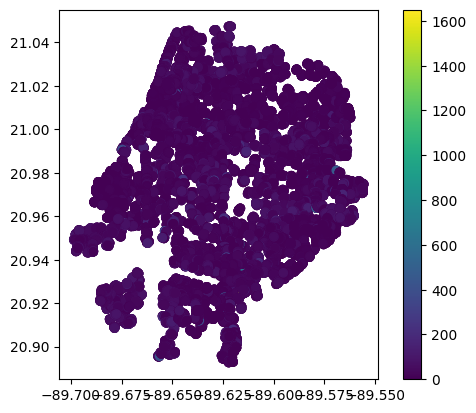

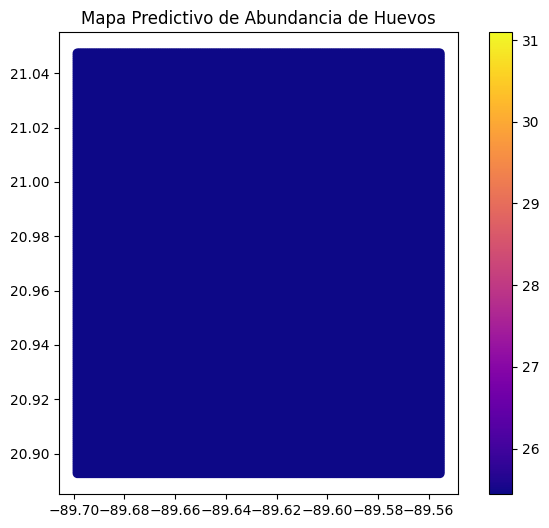

In [6]:
# --- Importar librerías ---
import pandas as pd
import geopandas as gpd
import numpy as np
from pykrige.ok import OrdinaryKriging
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
from shapely.geometry import Point
from rasterio.transform import from_origin

# --- Cargar y preparar los datos ---
df = pd.read_csv("eggs_data_base_COMPLETA_FINAL_MENSUAL.csv")
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat), crs="EPSG:4326")

# --- Exploración inicial ---
print(gdf.describe())
gdf.plot(column='eggs', cmap='viridis', legend=True)

# --- Definir variables predictoras ---
X = df[['elev_srtm', 'built_frac', 'temp_media_hist', 'Densidad_Pob_LOC',
        'GRAPROES', 'tmax_08', 'prcp_08']]
y = df['eggs']

# --- División entrenamiento/prueba ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Modelo Machine Learning ---
rf = RandomForestRegressor(n_estimators=300, random_state=42)
rf.fit(X_train, y_train)

# --- Validación ---
y_pred = rf.predict(X_test)
print("R²:", r2_score(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

# --- Generar malla para predicción ---
x_grid = np.linspace(df.lon.min(), df.lon.max(), 200)
y_grid = np.linspace(df.lat.min(), df.lat.max(), 200)
xx, yy = np.meshgrid(x_grid, y_grid)

# Crear DataFrame con puntos de predicción
grid_points = pd.DataFrame({
    'x': xx.ravel(),
    'y': yy.ravel()
})

# Agregar variables espaciales interpoladas o satelitales aquí (si están disponibles)
# Since spatial variables were excluded from the initial X, fill grid_points with median values
for col in X.columns:
  grid_points[col] = df[col].median()


# Predecir valores de eggs en la malla
preds = rf.predict(grid_points[['elev_srtm', 'built_frac', 'temp_media_hist',
                                'Densidad_Pob_LOC', 'GRAPROES', 'tmax_08', 'prcp_08']])
grid_points['pred_eggs'] = preds

# --- Convertir a GeoDataFrame ---
gdf_pred = gpd.GeoDataFrame(grid_points, geometry=gpd.points_from_xy(grid_points.x, grid_points.y), crs="EPSG:4326")

# --- Visualización del mapa predictivo ---
fig, ax = plt.subplots(figsize=(8,6))
gdf_pred.plot(column='pred_eggs', cmap='plasma', legend=True, ax=ax)
plt.title("Mapa Predictivo de Abundancia de Huevos")
plt.show()